### Яндекс Практикум, курс "Инженер Машинного Обучения" (2024 г.)
### Проект 4-го спринта: "Создание рекомендательной системы"
### Ноутбук для предобработки данных и EDA

### Описание данных

Данные - специально подготовленная выборка из полного набора, описанного здесь: https://mengtingwan.github.io/data/goodreads#datasets с дополнениями из https://www.kaggle.com/datasets/austinreese/goodreads-books:
- books: перечень книг (~44 тыс.) из списка https://www.goodreads.com/list/show/1.Best_Books_Ever (совпадение по book id),
- interactions: взаимодействие пользователей с книгами

Основной массив данных был собран в конце 2017.

### Инициализация

In [1]:
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import sys

# Проверяем, в каком окружении работаем
print(sys.executable)

c:\Users\Kirill_Nosov\_Repos\.venv\Scripts\python.exe


In [4]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

Создаём логгер, который удобен для использования в ноутбуке.

### Load Data

Загружаем данные как они есть, начинаем на них смотреть: какие в них есть сущности, атрибуты, распределения.

In [15]:
#!python -m wget -o tracks.parquet https://storage.yandexcloud.net/mle-data/ym/tracks.parquet
#!python -m wget -o catalog_names.parquet https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet
!python -m wget -o interactions.parquet https://storage.yandexcloud.net/mle-data/ym/interactions.parquet

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Kirill_Nosov\_Repos\.venv\Lib\site-packages\wget.py", line 568, in <module>
    filename = download(args[0], out=options.output)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kirill_Nosov\_Repos\.venv\Lib\site-packages\wget.py", line 526, in download
    (tmpfile, headers) = ulib.urlretrieve(binurl, tmpfile, callback)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill_Nosov\anaconda3\Lib\urllib\request.py", line 241, in urlretrieve
    with contextlib.closing(urlopen(url, data)) as fp:
                            ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill_Nosov\anaconda3\Lib\urllib\request.py", line 216, in urlopen
    return opener.open(url, data, timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill_Nosov\anaconda3\Lib\urllib\request.py", line

In [9]:
tracks = pd.read_parquet("tracks.parquet")
tracks

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


In [8]:
catalog_names = pd.read_parquet("catalog_names.parquet")
catalog_names

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


In [10]:
interactions = pd.read_parquet("interactions.parquet")
interactions

FileNotFoundError: [Errno 2] No such file or directory: 'interactions.parquet'

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43312 entries, 3 to 2360448
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   book_id               43312 non-null  int64  
 1   author                43312 non-null  object 
 2   title                 43312 non-null  object 
 3   description           43312 non-null  object 
 4   genre_and_votes       43312 non-null  object 
 5   num_pages             37001 non-null  Int64  
 6   average_rating        43312 non-null  float64
 7   ratings_count         43312 non-null  Int64  
 8   text_reviews_count    43312 non-null  int64  
 9   publisher             43312 non-null  object 
 10  publication_year      35891 non-null  Int64  
 11  country_code          43312 non-null  object 
 12  language_code         43312 non-null  object 
 13  format                43312 non-null  object 
 14  is_ebook              43312 non-null  bool   
 15  isbn                  

Пример данных по книгам

In [7]:
print(books[["book_id", "author", "title", "num_pages", "average_rating"]].sample(5, random_state=52).sort_values("book_id").set_index("book_id").to_string())

                                             author                                            title  num_pages  average_rating
book_id                                                                                                                        
69882                 Heinrich Böll, Patrick Bowles                      Billiards at Half-Past Nine        288            3.93
267533                               Robert Cormier                                         8 Plus 1        173            3.67
820966    Martin Luther, J.I. Packer, O.R. Johnston                          The Bondage of the Will        322            4.17
4532622                               Karen Hancock                                      The Enclave        492            3.82
20444381                             Diana Gabaldon  Os tambores de outono - 1ª Parte (Outlander #4)       1048            3.99


In [ ]:
#!python -m wget -o goodsread/interactions.parquet https://storage.yandexcloud.net/mle-data/goodsread/interactions.parquet

In [8]:
interactions = pd.read_parquet("./goodsread/interactions.parquet")

Можно оценить объём данных о взаимодействиях

In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12890434 entries, 0 to 12914458
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   book_id      int64 
 2   started_at   object
 3   read_at      object
 4   is_read      bool  
 5   rating       int64 
 6   is_reviewed  bool  
dtypes: bool(2), int64(2), object(3)
memory usage: 614.7+ MB


Пример данных по взаимодействиям

In [10]:
print(interactions[["user_id", "book_id", "started_at", "read_at", "is_read", "rating"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "book_id"]).to_string())

                                           started_at     read_at  is_read  rating
user_id                          book_id                                          
0447747f44c0d8d1a08cf329fe253f29 10054335  2016-04-08  2016-04-20     True       3
14432756ffba6357686f09e4ccc332bb 26252859  2016-05-27  2016-05-30     True       5
46d6c8cf548d1c86abb671f42ba71b5e 960       2014-08-06  2016-10-29     True       5
71c2b3714945af1f700f49953904c510 18492859  2014-10-09  2014-10-12     True       5
7802bafdeac8abff23a72b9dd60b1dd1 18710190  2015-03-01  2015-05-05     True       4


### EDA

Посмотрим на данные о книгах, какие поля есть.

In [11]:
books.sample(3).T

,1283019,1803052,202580
book_id,17561022,11929939,1348596
author,"Jessica Clare, Kerstin Fricke",Allison Pang,S.L. Farrell
title,Stranded with a Billionaire (Billionaire Boys ...,"A Sliver of Shadow (Abby Sinclair, #2)","A Magic of Twilight (The Nessantico Cycle, #1)"
description,The Billionaire Boys Club is a secret society ...,Just when her new life as a TouchStone -- a mo...,
genre_and_votes,"{'Romance': 402, 'Romance-Contemporary Romance...","{'Fantasy-Urban Fantasy': 144, 'Fantasy-Parano...","{'Fantasy': 85, 'Fiction': 15, 'Fantasy-Epic F..."
num_pages,215,384,546
average_rating,3.86,3.94,3.47
ratings_count,10326,2012,418
text_reviews_count,649,170,31
publisher,Penguin Group (USA),Pocket,


Посмотрим на данные о взаимодействиях пользователей с книгами.

In [12]:
books["book_id"].nunique()

43312

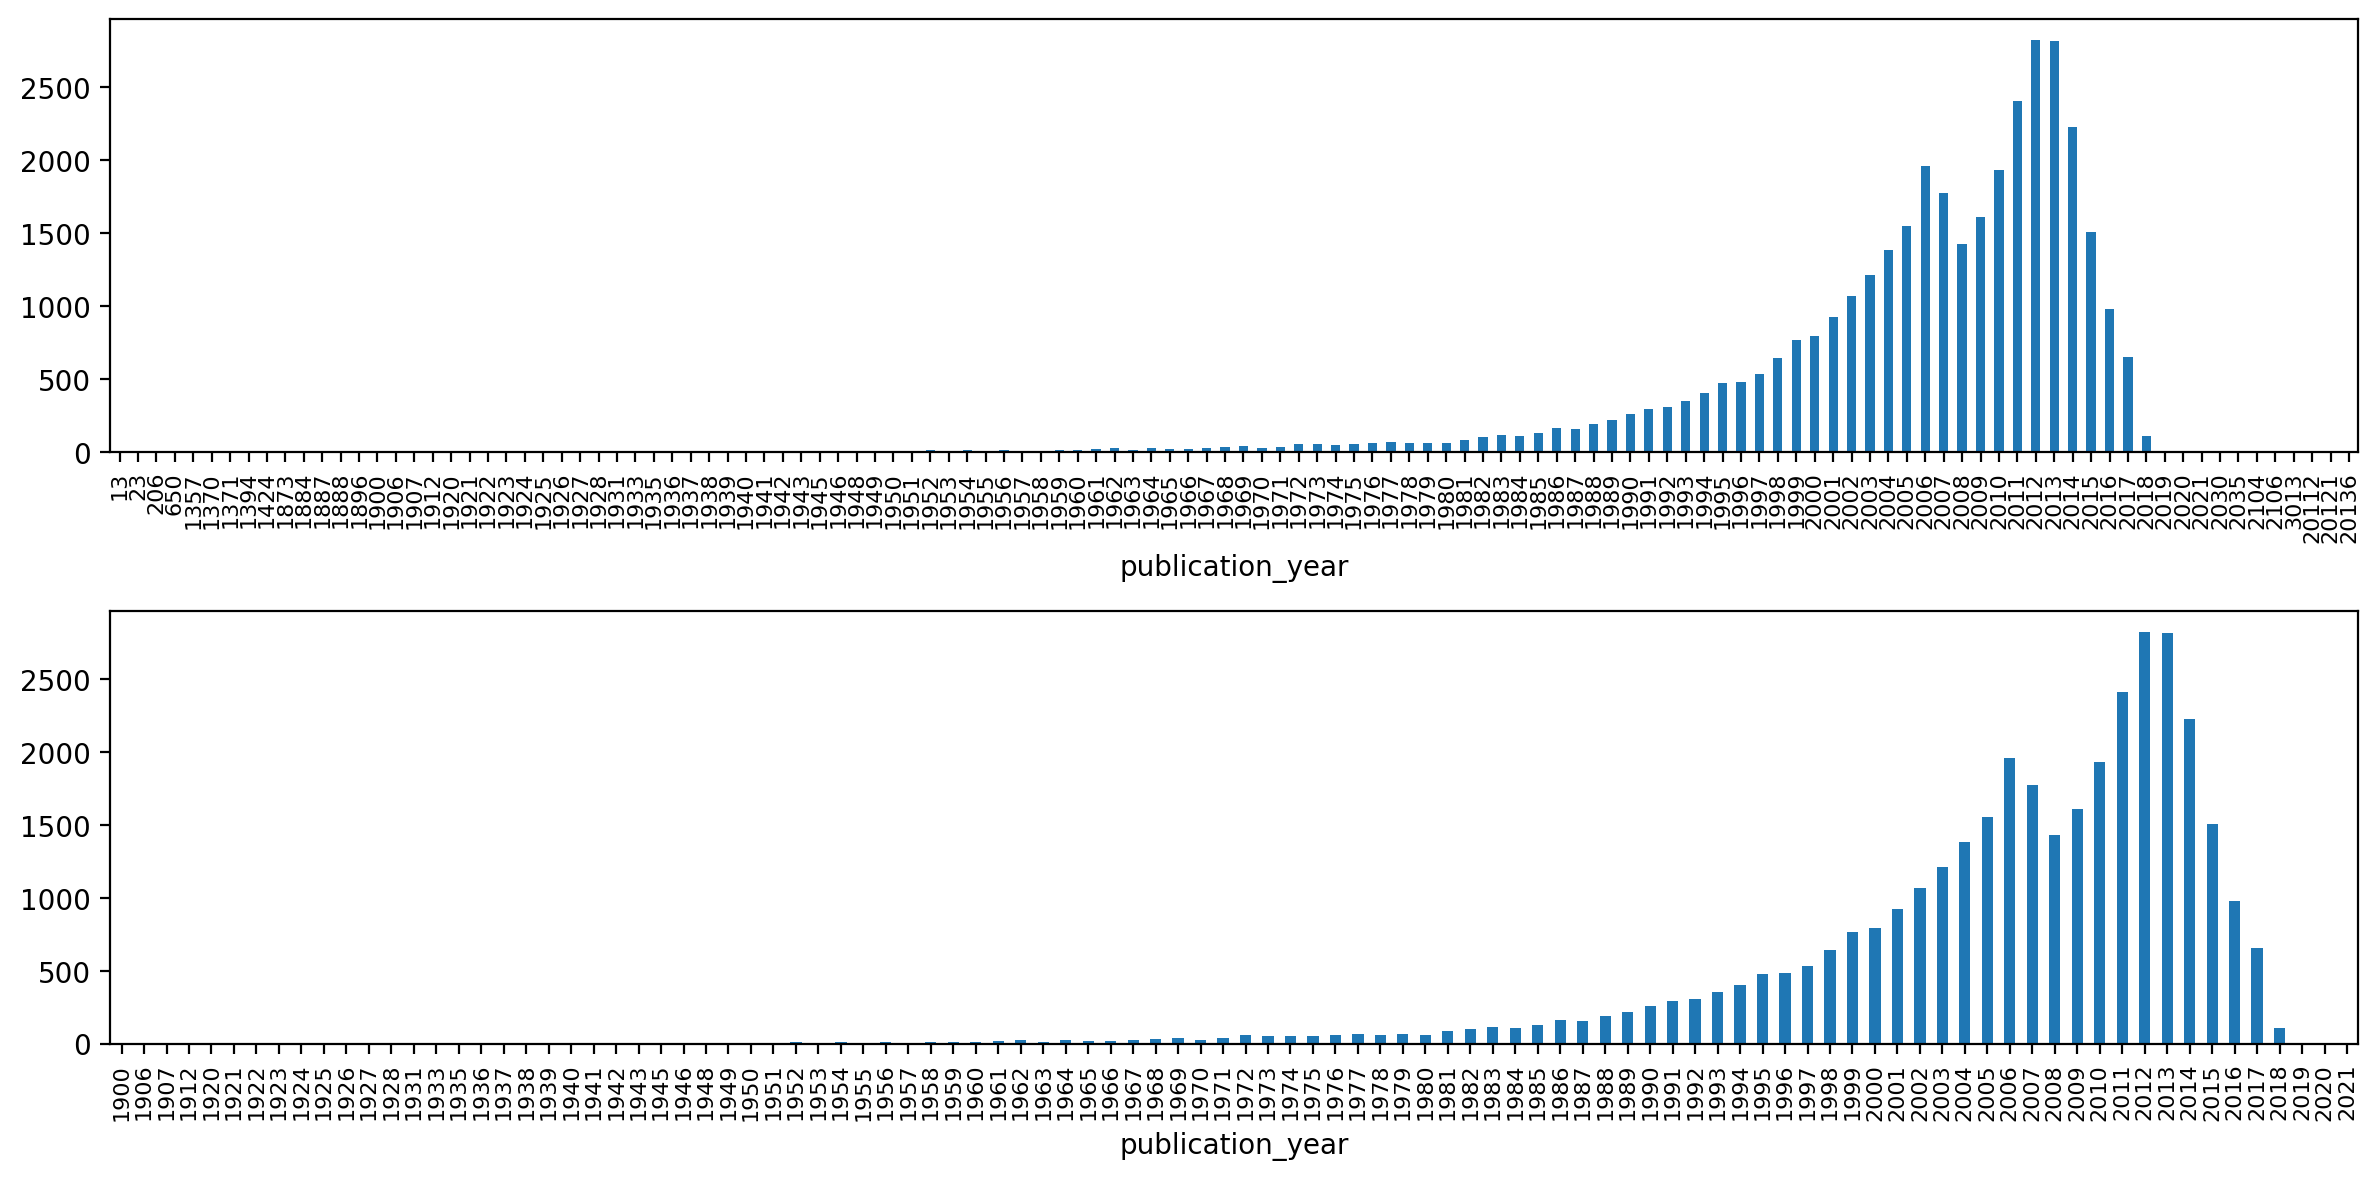

In [13]:
# распределение книг по годам публикации

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
books["publication_year"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.tick_params(axis='x', labelsize=8)

ax = axs[1]
books.query("publication_year >= 1900 and publication_year <= 2025")["publication_year"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.tick_params(axis='x', labelsize=8)

fig.tight_layout()

### События по месяцам

In [14]:
from pandas.tseries.offsets import MonthEnd

interactions["started_at_month"] = pd.to_datetime(interactions["started_at"]).dt.to_period('M').dt.to_timestamp().dt.date

In [15]:
interactions_by_month = interactions.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()

In [16]:
interactions_by_month

,started_at_month,events,users
0,2007-01-01,1993,1071
1,2007-02-01,201,135
2,2007-03-01,222,152
3,2007-04-01,201,135
4,2007-05-01,204,138
...,...,...,...
127,2017-08-01,202129,93040
128,2017-09-01,172187,82694
129,2017-10-01,108107,58076
130,2017-11-01,565,475


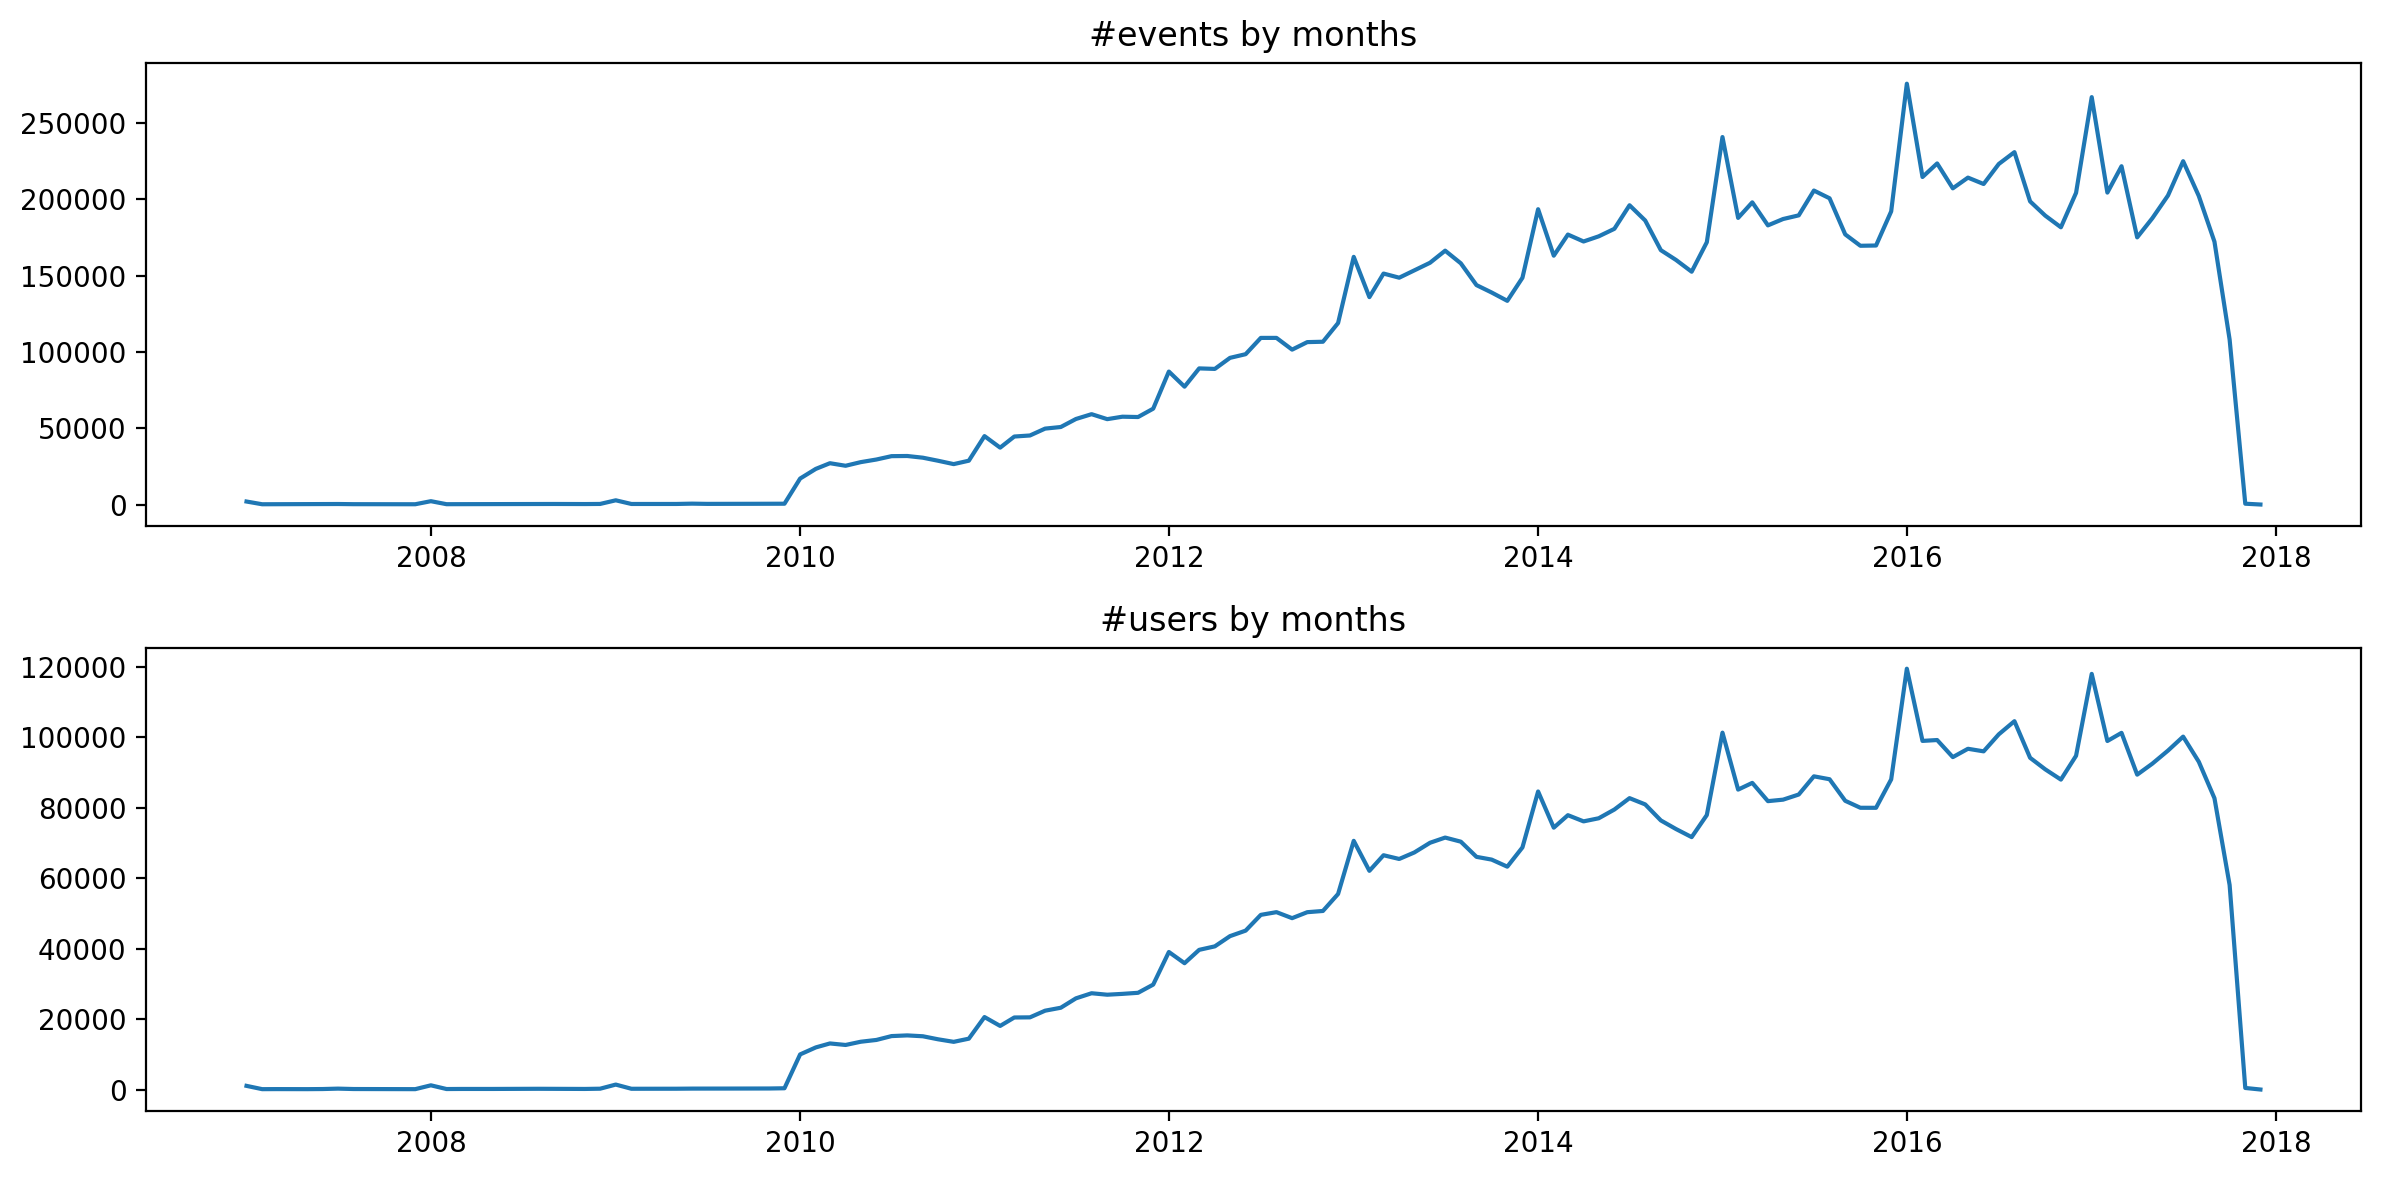

In [17]:
# распределение взаимодействий по годам

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

### Предобработка

Примем новые именования:
- books -> items (более обобщённое название)
- interactions -> events (несколько короче, удобнее в коде)

In [18]:
items = books.copy()
events = interactions.copy()

In [19]:
# Кол-во взаимодействий до предобработки
initial_events_len = len(events)
print(initial_events_len)

12890434


In [20]:
del books
del interactions

In [21]:
# Оставим события только до ноября 2017

event_cutoff_date = pd.to_datetime("2017-11-01").date()
events = events.query("started_at < @event_cutoff_date and read_at < @event_cutoff_date").copy()

### Ваш код здесь

In [22]:
# Удалите события, для которых нет рейтинга
events.drop(events[events['rating'] == 0].index, inplace=True)

In [23]:
# Оставьте события только c признаком is_read=True
events.drop(events[events['is_read'] == False].index, inplace=True)

In [24]:
# Оставьте только тех пользователей, у которых две и более прочитанных книги
agg_users = events.groupby("user_id").agg(books=("book_id", "nunique"))
filtered_users = agg_users[agg_users['books'] >= 2]
filtered_users

,books
user_id,
00000377eea48021d3002730d56aca9a,29
00004584d524ec468619e81b176cc991,2
000079c580bbe45e1500acabe551b276,4
00009e46d18f223a82b22da38586b605,95
0000c3d51aa099745e93a4e99c4856c8,133
...,...
ffff7cf38c717c8172ff5ba656cec6df,3
ffffbb062a8b208c9c1031b529c08f7a,8
ffffd81a724c0fa70ac37cd347c1c0f1,3


In [25]:
events = events[events['user_id'].isin(filtered_users.index)]
events

,user_id,book_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month
0,8842281e1d1347389f2ab93d60773d4d,22034,2015-07-12,2015-07-17,True,5,False,2015-07-01
1,8842281e1d1347389f2ab93d60773d4d,22318578,2015-06-07,2015-08-09,True,5,True,2015-06-01
2,8842281e1d1347389f2ab93d60773d4d,22551730,2015-06-24,2015-07-11,True,4,True,2015-06-01
3,8842281e1d1347389f2ab93d60773d4d,22816087,2015-09-27,2015-11-04,True,5,True,2015-09-01
5,8842281e1d1347389f2ab93d60773d4d,17910054,2015-03-04,2015-07-28,True,3,False,2015-03-01
...,...,...,...,...,...,...,...,...
12914452,d890e8079d8896e0cc6c4f178634850a,5297,2017-02-07,2017-02-26,True,5,False,2017-02-01
12914453,d890e8079d8896e0cc6c4f178634850a,4900,2016-12-22,2016-12-29,True,2,False,2016-12-01
12914454,d890e8079d8896e0cc6c4f178634850a,14836,2016-11-29,2017-01-15,True,3,False,2016-11-01
12914456,b0883ebf8e31731f1c5d91e678c26666,10210,2012-06-05,2013-01-17,True,5,False,2012-06-01


Перекодируйте идентификаторы пользователей из символьного вида (92f960b6da4be49c7955794c6331d759) в числовой. Все оставшиеся после обработки данных идентификаторы нужно отсортировать по возрастанию и последовательно пронумеровать, начиная с 1 000 000. Эти значения и будут новыми идентификаторами пользователей.

In [26]:
# Сначала сортируем по символьным user_id
events = events.sort_values('user_id')
events

,user_id,book_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month
6679625,00000377eea48021d3002730d56aca9a,11012,2015-12-05,2015-12-11,True,4,False,2015-12-01
6679617,00000377eea48021d3002730d56aca9a,4671,2014-06-05,2014-06-30,True,5,False,2014-06-01
6679618,00000377eea48021d3002730d56aca9a,5,2012-10-02,2012-10-24,True,5,False,2012-10-01
6679620,00000377eea48021d3002730d56aca9a,2,2009-07-12,2009-07-29,True,5,False,2009-07-01
6679621,00000377eea48021d3002730d56aca9a,14497,2016-05-09,2016-06-02,True,5,False,2016-05-01
...,...,...,...,...,...,...,...,...
5625379,fffff8a718843c0e11dfd93fb41c1297,25111004,2016-12-08,2016-12-08,True,5,False,2016-12-01
5625378,fffff8a718843c0e11dfd93fb41c1297,6606855,2017-03-01,2017-03-01,True,3,False,2017-03-01
5625377,fffff8a718843c0e11dfd93fb41c1297,18812405,2017-05-05,2017-05-31,True,3,True,2017-05-01
5625376,fffff8a718843c0e11dfd93fb41c1297,18692431,2017-08-02,2017-08-09,True,3,True,2017-08-01


In [27]:
# Сохраняем старые символьные user_id и присваиваем им новые числовые значения, начиная с 1e6
events['old_user_id'] = events['user_id']
events['user_id'] = events['user_id'].rank(method='dense').astype(int)
events['user_id'] += 999999
events

,user_id,book_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month,old_user_id
6679625,1000000,11012,2015-12-05,2015-12-11,True,4,False,2015-12-01,00000377eea48021d3002730d56aca9a
6679617,1000000,4671,2014-06-05,2014-06-30,True,5,False,2014-06-01,00000377eea48021d3002730d56aca9a
6679618,1000000,5,2012-10-02,2012-10-24,True,5,False,2012-10-01,00000377eea48021d3002730d56aca9a
6679620,1000000,2,2009-07-12,2009-07-29,True,5,False,2009-07-01,00000377eea48021d3002730d56aca9a
6679621,1000000,14497,2016-05-09,2016-06-02,True,5,False,2016-05-01,00000377eea48021d3002730d56aca9a
...,...,...,...,...,...,...,...,...,...
5625379,1430584,25111004,2016-12-08,2016-12-08,True,5,False,2016-12-01,fffff8a718843c0e11dfd93fb41c1297
5625378,1430584,6606855,2017-03-01,2017-03-01,True,3,False,2017-03-01,fffff8a718843c0e11dfd93fb41c1297
5625377,1430584,18812405,2017-05-05,2017-05-31,True,3,True,2017-05-01,fffff8a718843c0e11dfd93fb41c1297
5625376,1430584,18692431,2017-08-02,2017-08-09,True,3,True,2017-08-01,fffff8a718843c0e11dfd93fb41c1297


__Задание 1 из 6__

In [28]:
# Какая доля событий осталась после обработки данных? (должно быть 91%)
print(len(events) / initial_events_len * 100)

91.16129061286843


In [29]:
# Какой новый идентификатор у пользователя с изначальным идентификатором 8f50136afeb65c55cec7b3d306c24b03
# должно быть 1241243
events[events['old_user_id'] == '8f50136afeb65c55cec7b3d306c24b03']

,user_id,book_id,started_at,read_at,is_read,rating,is_reviewed,started_at_month,old_user_id
10841363,1241243,253058,2012-12-29,2013-01-22,True,3,True,2012-12-01,8f50136afeb65c55cec7b3d306c24b03
10841364,1241243,10572,2012-01-02,2013-01-27,True,5,False,2012-01-01,8f50136afeb65c55cec7b3d306c24b03


__Задание 2 из 6__

Завершите код для разбиения всех событий. В качестве точки разбиения используйте 2017-08-01, то есть отнесите в тестовую часть три последних месяца.

Кол-во уникальных пользователей, которые есть и в events_train, и в events_test, должно быть равно 120858

In [30]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx] # your code here
events_test = events[~train_test_global_time_split_idx]

# Пользователи в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates() # ваш код здесь 
# Пользователи, которые есть и в train и в test
common_users = users_train[users_train.isin(users_test)] # ваш код здесь #

print(len(users_train), len(users_test), len(common_users))

428220 123223 120858


__Задание 3 из 6__

«Холодные» пользователи — те, которые есть в test, но отсутствуют в train. Это соответствует хронологическому порядку, в котором и работает рекомендательная система.

Идентифицируйте холодных пользователей и оцените их количество (должно быть 2365)

In [31]:
cold_users = users_test[~users_test.isin(users_train)] # ваш код здесь

print(len(cold_users))

2365


__Задание 4 из 6__

Найдите топ-100 наиболее популярных книг (учитывая их среднюю оценку) за последние несколько лет. 
Например, с 2015 года и со средней оценкой не меньше 4. Их вы и будете рекомендовать «холодным» пользователям.

In [32]:
top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["book_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()
item_popularity["popularity_weighted"] = item_popularity["users"] * item_popularity["avg_rating"]

# сортируем по убыванию взвешенной популярности
item_popularity = item_popularity.sort_values('popularity_weighted', ascending=False) # ваш код здесь

# выбираем первые 100 айтемов со средней оценкой avg_rating не меньше 4
top_k_pop_items = item_popularity[item_popularity['avg_rating'] >= 4].iloc[:100].reset_index() # ваш код здесь

Сколько пользователей оценило книгу, попавшую на первое место в top_k_pop_items? (должно быть 20207)

In [33]:
print(top_k_pop_items.loc[0, 'users'])
top_k_pop_items

20207


,index,book_id,users,avg_rating,popularity_weighted
0,32387,18007564,20207,4.321275,87320.0
1,32623,18143977,19462,4.290669,83505.0
2,30695,16096824,16770,4.301014,72128.0
3,2,3,15139,4.706057,71245.0
4,3718,38447,14611,4.232770,61845.0
...,...,...,...,...,...
95,19596,2767052,4361,4.413437,19247.0
96,32835,18293427,4674,4.092640,19129.0
97,378,3636,4667,4.098564,19128.0
98,33611,18966819,4361,4.374914,19079.0


__Задание 5 из 6__

Завершите предлагаемый код, чтобы в cold_users_events_with_recs для каждого события получить столбец avg_rating. В нём при совпадении по item_id будет значение из одноимённого столбца из top_k_pop_items, иначе - пропуск.
В cold_users_events_with_recs после выполнения завершённого кода должно быть столько же строк, что и до его выполнения.


In [34]:
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items, on="book_id", how="left") # ваш код здесь 

cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "book_id", "rating", "avg_rating"]]

Для какой доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items совпали по книгам? Округлите ответ до сотых (должно быть 0.8023).

In [37]:
cold_user_recs_matched = cold_user_recs[round(cold_user_recs.avg_rating) == cold_user_recs.rating]
cold_user_recs_matched

,user_id,book_id,rating,avg_rating
27,1002222,15839976,4,4.150180
36,1002881,5470,4,4.124738
41,1002912,25899336,4,4.427261
83,1006338,17927395,5,4.730640
117,1007492,17927395,5,4.730640
...,...,...,...,...
9617,1428390,15881,5,4.632447
9625,1428973,5,5,4.770143
9629,1429284,136251,5,4.850775
9638,1429316,18584855,4,4.071619


In [38]:
cold_user_recs_matched_share = len(cold_user_recs_matched) / len(cold_user_recs)
print(round(cold_user_recs_matched_share, 2))

0.44


__Задание 6 из 6__

Посчитайте метрики rmse и mae для полученных рекомендаций. Какое значение метрики MAE получилось? Приведите минимум два знака после запятой (должно быть 0.62)

In [39]:

# посчитаем метрики рекомендаций
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(cold_user_recs["rating"], cold_user_recs["avg_rating"], squared=False)
mae = mean_absolute_error(cold_user_recs["rating"], cold_user_recs["avg_rating"]) # ваш код здесь 
print(round(rmse, 2), round(mae, 2))

0.78 0.62


Полученная метрика — значение, на которое оценка рекомендации в среднем отклоняется от истинной. Это отклонение выглядит небольшим, но в данном случае стоит оценить и покрытие как по пользователям, так и по объектам, ведь рекомендации, скорее всего, имеют мало пересечений с оценками пользователей. 

In [40]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


### Сохранение результатов

In [41]:
items.to_parquet("goodsread/items.par")

In [42]:
events.to_parquet("goodsread/events.par")